In [1]:
from baselines.common.plot_util import smooth,one_sided_ema,symmetric_ema,load_results,default_xy_fn,default_split_fn,regression_analysis,test_smooth
import matplotlib.pyplot as plt
import numpy as np
import os.path as osp
import json
import os
import pandas
from collections import defaultdict, namedtuple
from baselines.bench import monitor
from baselines.logger import read_json, read_csv
import pickle
from matplotlib.ticker import EngFormatter

COLORS = ['#66624b', '#41c1dd', '#3e9651', '#e0771a', '#660066', '#b2a745', '#cc2529',]

In [2]:
def moving_average(a, n=10):
    plot_data = np.zeros_like(a)
    for idx in range(len(a)):
        length = min(idx, n)
        plot_data[idx] = a[idx-length:idx+1].mean()
    return plot_data

In [3]:
def uneq_mean(data):
    max_len = 0
    for idx in range(len(data)):
        max_len = max(max_len, len(data[idx]))
        
    ret_vec = np.zeros(max_len)
    for vec_idx in range(max_len):
        vals = []
        for idx in range(len(data)):
            try:
                val = data[idx][vec_idx]
                vals.append(val)
            except:
                pass
        ret_vec[vec_idx] = np.mean(vals)
    return ret_vec

def uneq_std(data):
    max_len = 0
    for idx in range(len(data)):
        max_len = max(max_len, len(data[idx]))
        
    ret_vec = np.zeros(max_len)
    for vec_idx in range(max_len):
        vals = []
        for idx in range(len(data)):
            try:
                val = data[idx][vec_idx]
                vals.append(val)
            except:
                pass
        ret_vec[vec_idx] = np.std(vals)
    return ret_vec

def uneq_stderr(data):
    max_len = 0
    for idx in range(len(data)):
        max_len = max(max_len, len(data[idx]))
        
    ret_vec = np.zeros(max_len)
    for vec_idx in range(max_len):
        vals = []
        for idx in range(len(data)):
            try:
                val = data[idx][vec_idx]
                vals.append(val)
            except:
                pass
        ret_vec[vec_idx] = np.std(vals) / np.sqrt(len(vals))
    return ret_vec

# Mean Performance Across 10 Seeds

Hopper
3691.5 ± 61.7
Humanoid
5194.0 ± 97.1
Walker2d
4328.8 ± 1059.0
Ant
3505.4 ± 411.7
HalfCheetah
10411.0 ± 1323.5
Swimmer
314.1 ± 69.2
InvertedPendulum
1000.0 ± 0.0
InvertedDoublePendulum
9350.6 ± 26.8
Reacher
-4.0 ± 0.3


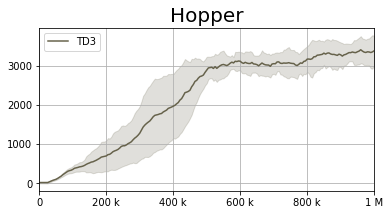

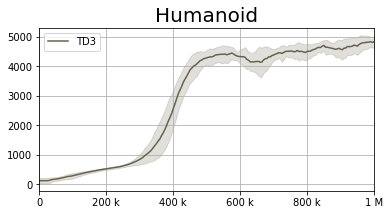

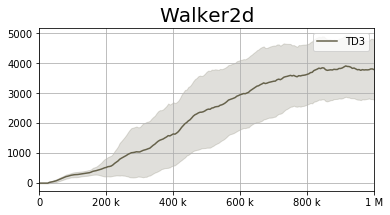

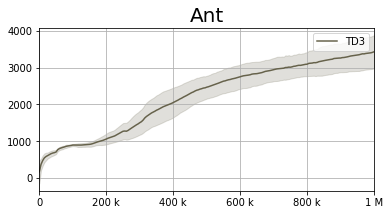

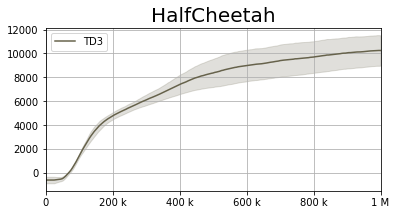

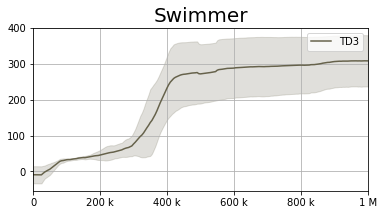

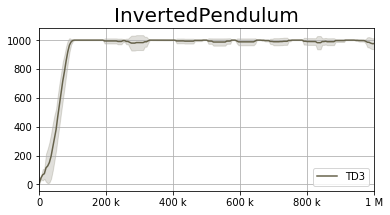

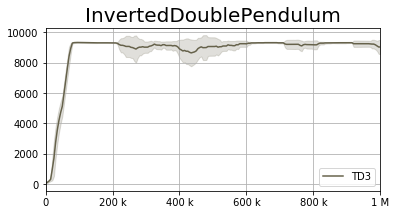

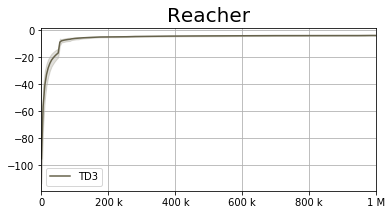

In [4]:
envs = ['Hopper', 'Humanoid', 'Walker2d', 'Ant', 'HalfCheetah', 'Swimmer', 'InvertedPendulum', 'InvertedDoublePendulum', 'Reacher']
all_envs_data = []
for env in envs:
    td3_results = []
    td3_max_results = []
    
    for i in range(10):
        try:
            data = np.load('./results/TD3/' + env + '-v2_' + str(i) + '.npy')
            td3_results.append(moving_average(data[:-1]))
            td3_max_results.append(data[-1])
        except:
            pass
    all_envs_data.append(td3_max_results)

    if len(td3_results) > 0:
        print(env)
        print(f"{round(np.mean(td3_max_results), 1)} ± {round(np.std(td3_max_results), 1)}")
        
        shaded_err = False
        shaded_std = True
        figsize = (6, 3)
        f, axarr = plt.subplots(1, 1, sharex=False, squeeze=False, figsize=figsize)
        idx = 0

        td3_results = np.array(td3_results)
        td3_x = np.linspace(0, 1000000, len(td3_results[0]))

        color = COLORS[idx]
        td3_mean = uneq_mean(td3_results)
        td3_std = uneq_std(td3_results)
        td3_stderr = uneq_stderr(td3_results)

        l, = axarr[0][0].plot(td3_x, td3_mean, color=color, label='TD3')

        if shaded_err:
            axarr[0][0].fill_between(td3_x, td3_mean - td3_stderr, td3_mean + td3_stderr, color=color, alpha=.4)
        if shaded_std:
            axarr[0][0].fill_between(td3_x, td3_mean - td3_std, td3_mean + td3_std, color=color, alpha=.2)
        idx += 1

        axarr[0][0].set_xlim(0, 1e6)
        axarr[0][0].grid(True)
        axarr[0][0].xaxis.set_major_formatter(EngFormatter())
        axarr[0][0].legend()
        axarr[0][0].set_title(env, fontsize=20)

(array([1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 9 Text xticklabel objects>)

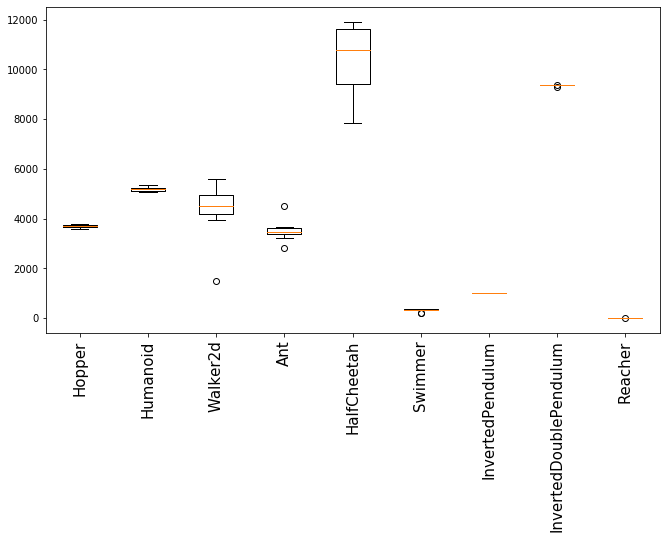

In [5]:
fig = plt.figure(1, figsize=(11, 6))

ax = fig.add_subplot(111)

# Create the boxplot
bp = ax.boxplot(all_envs_data)
ax.set_xticklabels(envs)
plt.xticks(rotation=90, fontsize=15)

# Per Seed Analysis

/home/chen/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


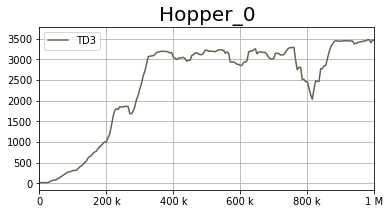

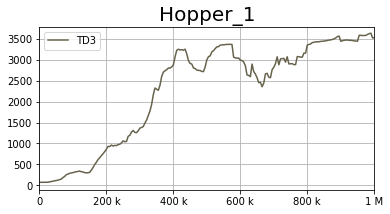

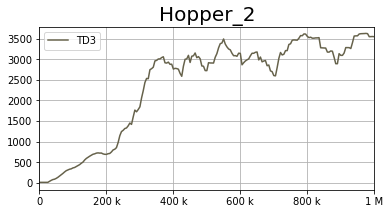

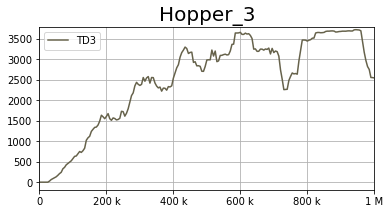

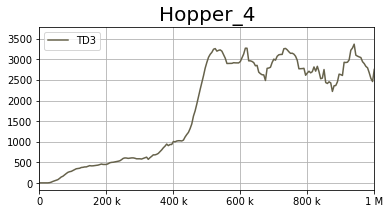

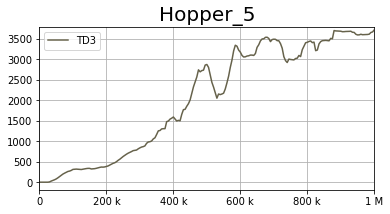

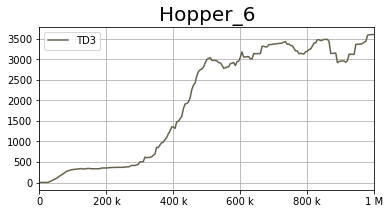

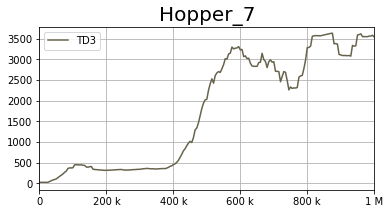

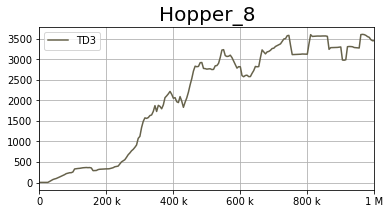

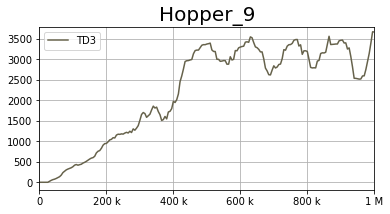

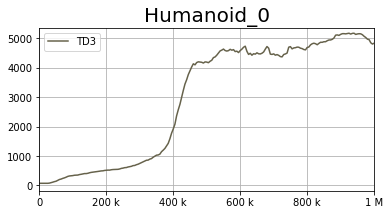

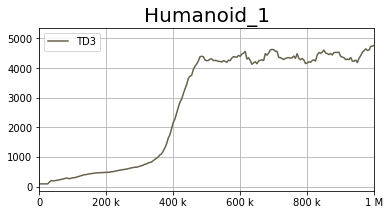

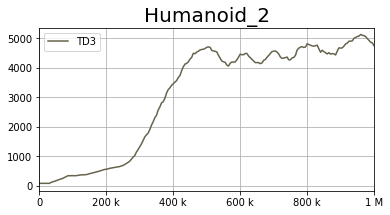

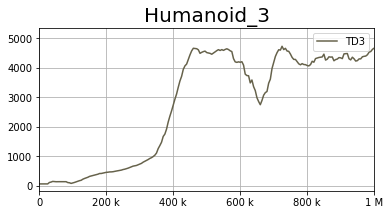

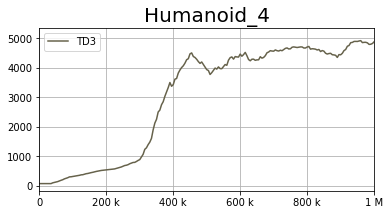

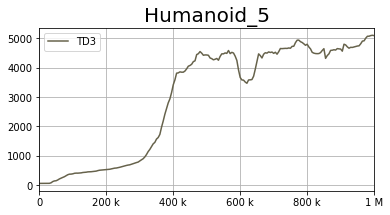

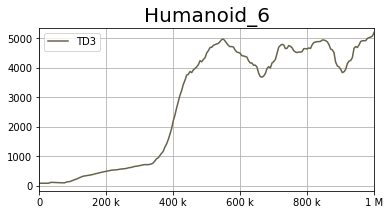

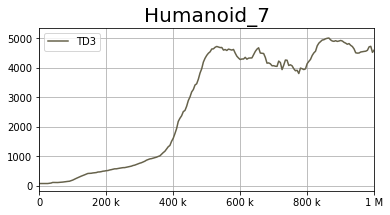

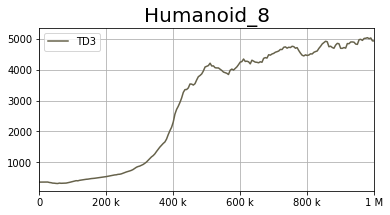

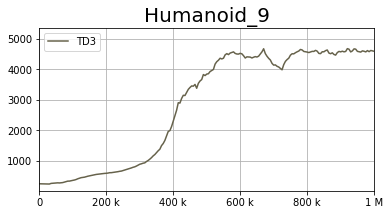

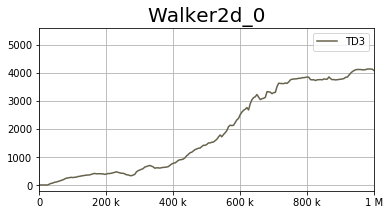

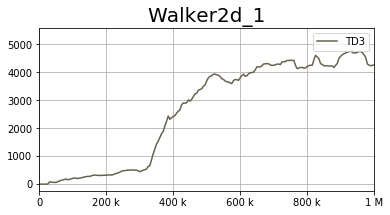

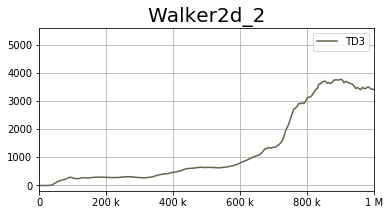

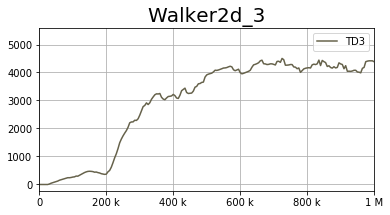

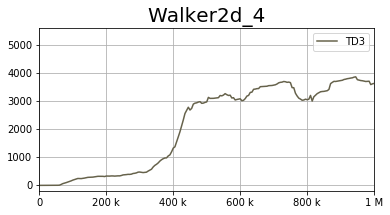

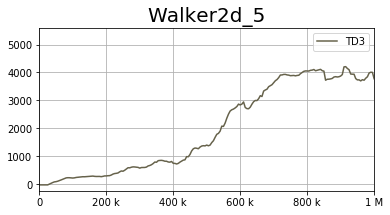

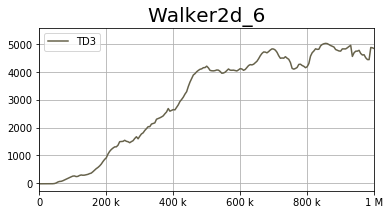

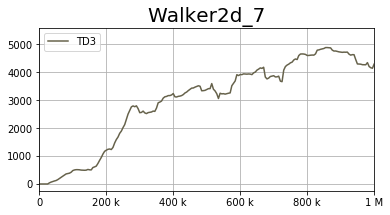

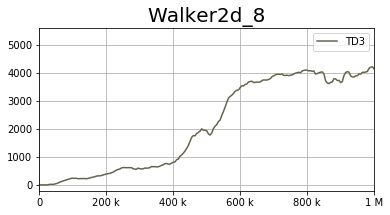

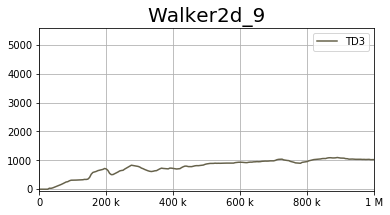

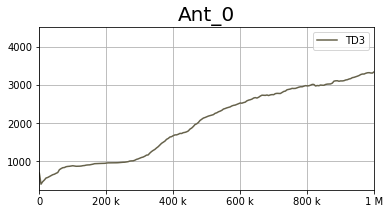

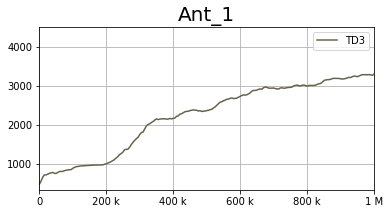

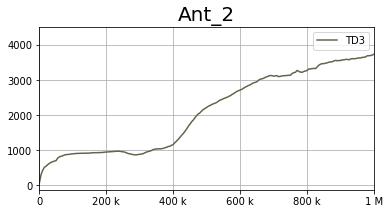

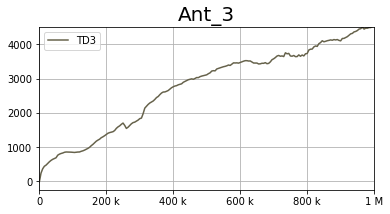

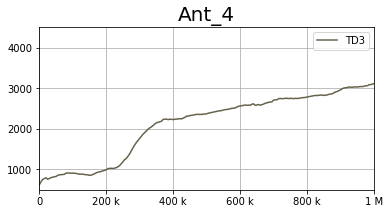

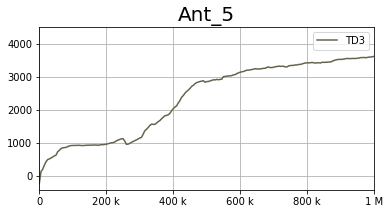

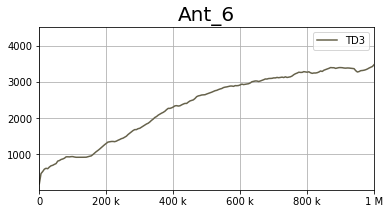

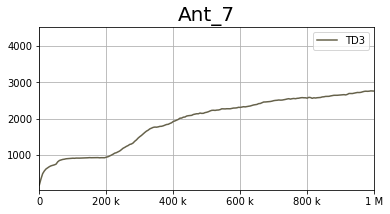

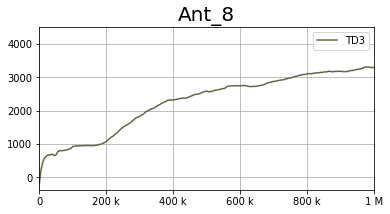

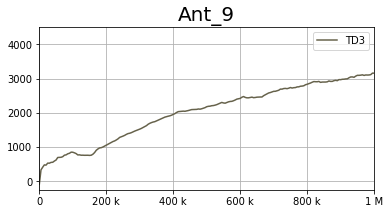

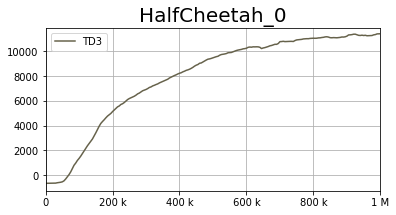

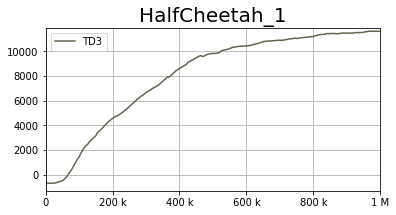

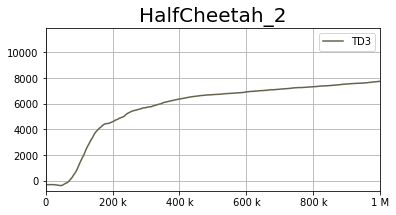

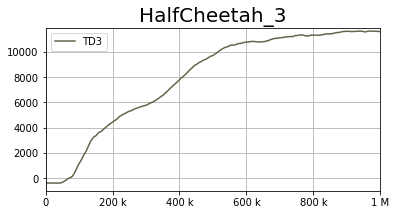

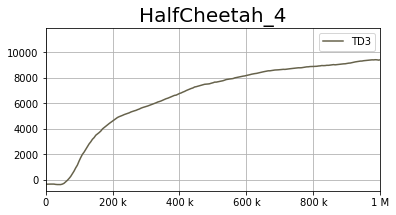

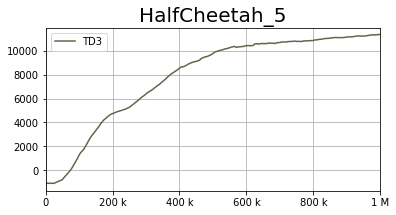

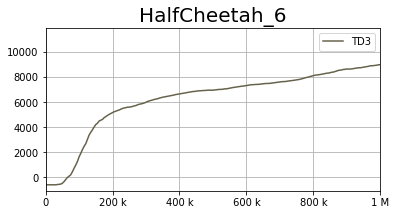

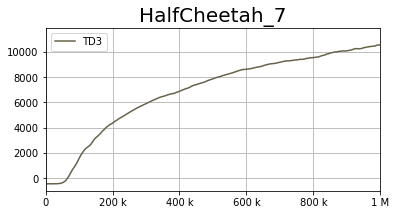

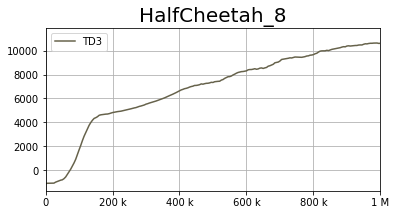

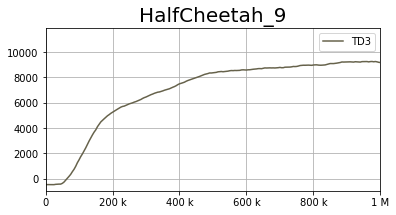

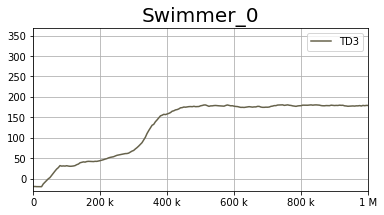

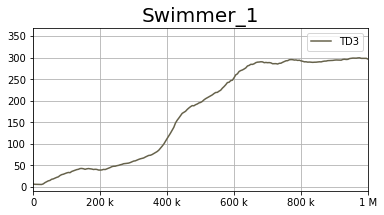

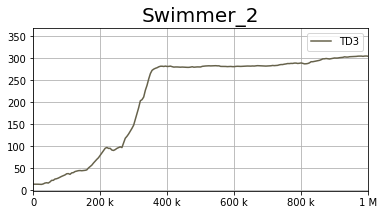

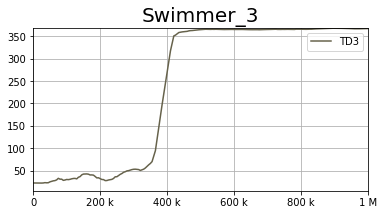

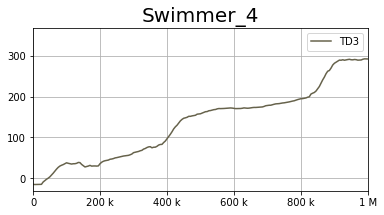

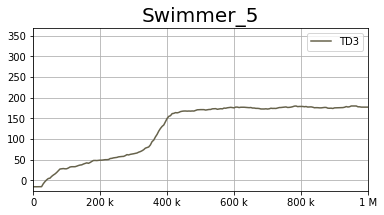

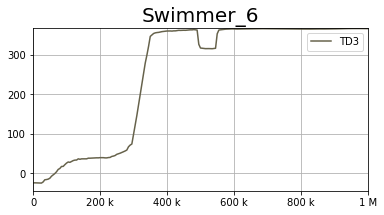

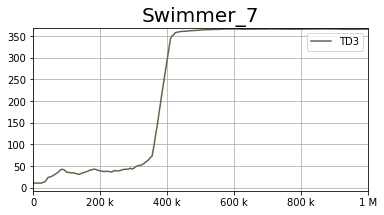

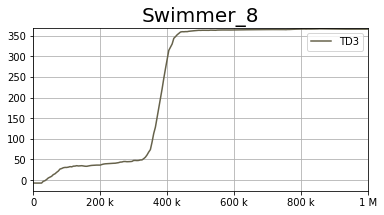

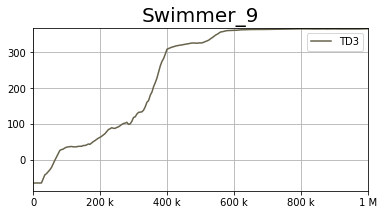

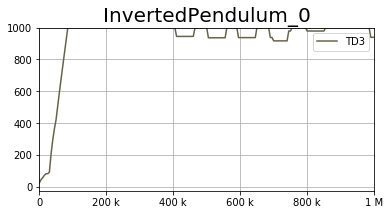

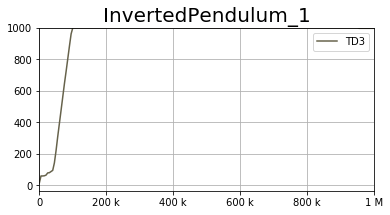

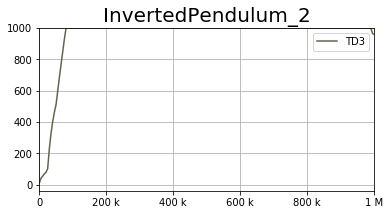

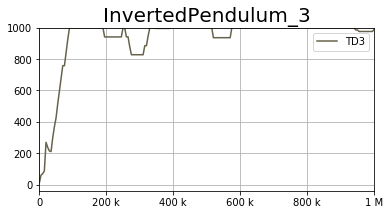

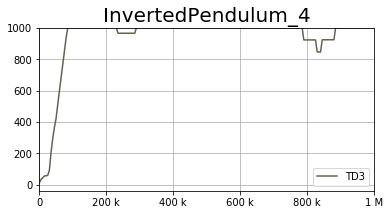

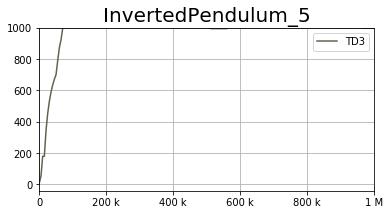

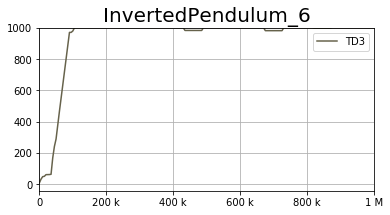

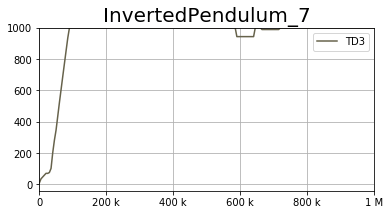

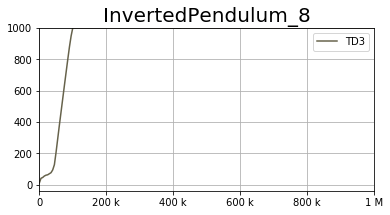

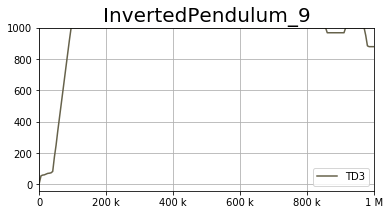

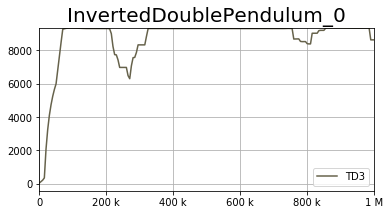

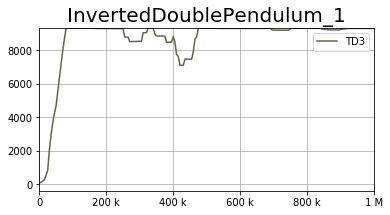

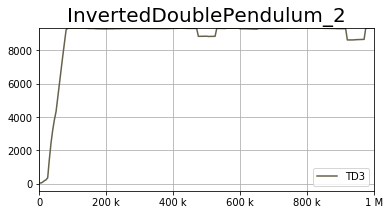

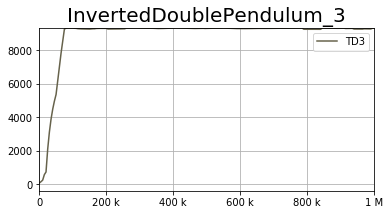

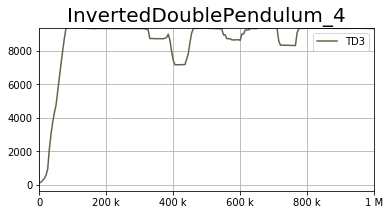

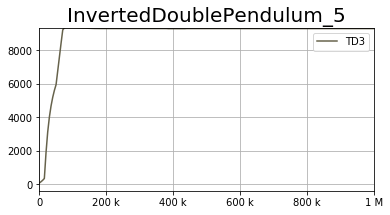

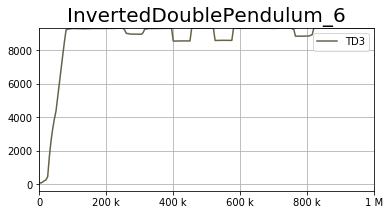

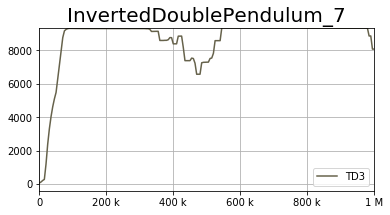

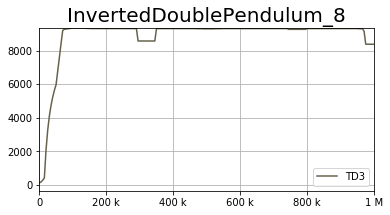

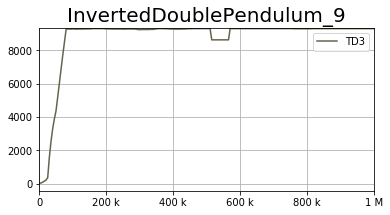

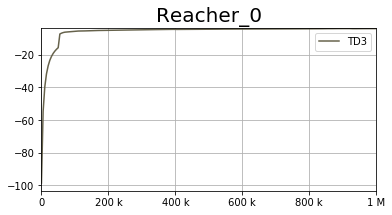

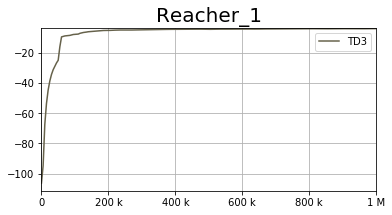

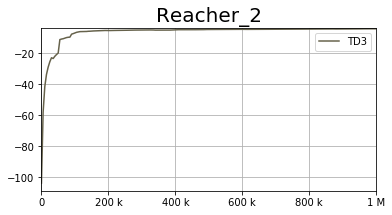

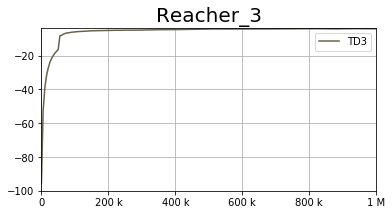

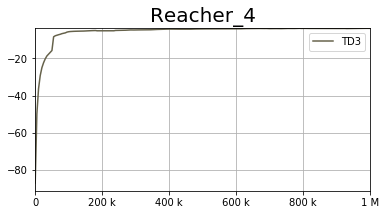

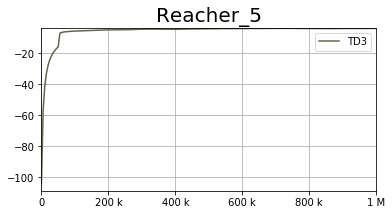

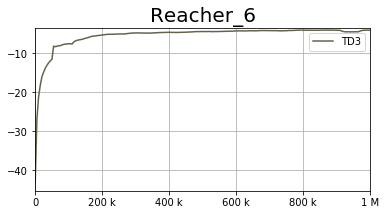

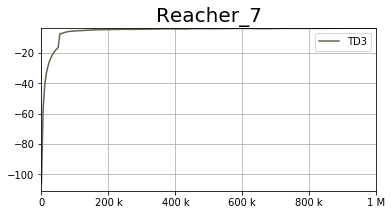

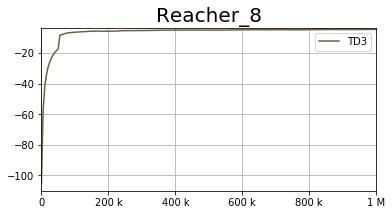

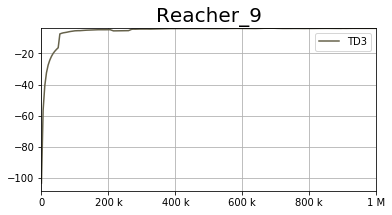

In [6]:
for env in ['Hopper', 'Humanoid', 'Walker2d', 'Ant', 'HalfCheetah', 'Swimmer', 'InvertedPendulum', 'InvertedDoublePendulum', 'Reacher']:
    td3_results = []
    td3_max_results = []
    
    for i in range(10):
        try:
            data = np.load('./results/TD3/' + env + '-v2_' + str(i) + '.npy')
            td3_results.append(moving_average(data[:-1]))
            td3_max_results.append(data[-1])
        except:
            pass

    if len(td3_results) > 0:
        for seed, data in enumerate(td3_results):
            shaded_err = False
            shaded_std = True
            figsize = (6, 3)
            f, axarr = plt.subplots(1, 1, sharex=False, squeeze=False, figsize=figsize)
            idx = 0

            td3_y = np.array(data)
            td3_x = np.linspace(0, 1000000, len(data))

            l, = axarr[0][0].plot(td3_x, td3_y, color=color, label='TD3')

            axarr[0][0].set_xlim(0, 1e6)
            axarr[0][0].set_ylim(top=max(td3_max_results))
            axarr[0][0].grid(True)
            axarr[0][0].xaxis.set_major_formatter(EngFormatter())
            axarr[0][0].legend()
            axarr[0][0].set_title(env + '_' + str(seed), fontsize=20)